In [223]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout,LSTM
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

In [224]:
# ============================
# GPU 内存增长配置（解决 CUDA 内存不足问题）
# ============================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # 设置每个GPU允许按需增长内存
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)
# ---------------------------
# 1. 数据加载与预处理
# ---------------------------
# 假设你的CSV文件名为 "qqq_data.csv"
data = pd.read_csv("D:\python\smoke_week_1.0_xgb\smokeweed_2.0\gru_model\简单版方案1训练数据.csv")

GPU memory growth enabled.


In [228]:
data=data[:50000]
data

,Unnamed: 0,timestamp,open,high,low,close,volume,rsi_1min,rsi_5min,rsi_30min,...,day_of_week,month,close_5min_change_pct,close_10min_change_pct,close_30min_change_pct,close_60min_change_pct,close_120min_change_pct,close_240min_change_pct,close_480min_change_pct,target
0,0,2019-01-02 04:00:00,145.156,145.208,144.945,144.999,10183,67.119465,71.548606,82.685061,...,2,1,0.001931,0.001600,0.004131,0.004862,0.003000,0.003400,0.030855,0
1,1,2019-01-02 04:01:00,145.060,145.111,144.888,145.086,4827,67.119465,71.548606,82.685061,...,2,1,0.000000,0.000862,0.002598,0.004528,0.001930,0.003198,0.029569,0
2,2,2019-01-02 04:02:00,145.060,145.150,144.984,145.125,4655,67.119465,71.548606,82.685061,...,2,1,0.000200,0.000861,-0.000338,0.004589,0.001991,0.002329,0.029292,0
3,3,2019-01-02 04:03:00,145.156,145.227,145.013,145.202,7990,67.119465,71.548606,82.685061,...,2,1,-0.000269,0.000530,-0.000269,0.003526,0.001660,0.001928,0.029015,0
4,4,2019-01-02 04:04:00,145.166,145.285,145.100,145.260,3100,67.119465,71.548606,82.685061,...,2,1,0.000000,0.000461,0.000330,0.002058,0.000799,0.001397,0.028535,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49515,49515,2019-04-08 16:29:00,179.269,179.319,179.214,179.279,2600,55.122151,68.949241,70.369762,...,0,4,-0.000162,0.000162,0.000268,-0.001567,-0.001026,-0.002432,-0.003347,0
49516,49516,2019-04-08 16:30:00,179.250,179.299,179.176,179.240,5480,48.022460,64.354540,71.091005,...,0,4,0.000000,0.000218,0.000379,-0.001512,-0.001350,-0.002427,-0.003186,0
49517,49517,2019-04-08 16:31:00,179.230,179.280,179.185,179.250,1000,49.807596,64.354540,71.091005,...,0,4,0.000162,0.000324,0.000106,-0.001406,-0.001300,-0.002271,-0.003621,0
49518,49518,2019-04-08 16:32:00,179.240,179.299,179.195,179.269,10000,53.103215,64.354540,71.091005,...,0,4,0.000056,0.000056,0.000000,-0.001456,-0.001188,-0.001941,-0.003564,0


In [230]:
# 计算相对当前时间点5分钟、10分钟、30分钟之后的价格变化
data['close_5min_change_pct'] = (data['close'].shift(-5) - data['close']) / data['close']
data['close_10min_change_pct'] = (data['close'].shift(-10) - data['close']) / data['close']
data['close_30min_change_pct'] = (data['close'].shift(-30) - data['close']) / data['close']
data['close_60min_change_pct'] = (data['close'].shift(-60) - data['close']) / data['close']
data['close_120min_change_pct'] = (data['close'].shift(-120) - data['close']) / data['close']
data['close_240min_change_pct'] = (data['close'].shift(-240) - data['close']) / data['close']
data['close_480min_change_pct'] = (data['close'].shift(-480) - data['close']) / data['close']
# 去除包含目标标签 NaN 的行
data.dropna(subset=['close_5min_change_pct', 'close_10min_change_pct', 'close_30min_change_pct','close_60min_change_pct','close_120min_change_pct','close_240min_change_pct','close_480min_change_pct'], inplace=True)

In [231]:
# 定义分类条件
conditions = [
    (data['close_240min_change_pct'] > 0.008),                  # 数值 > 0.008
    (data['close_240min_change_pct'] < -0.008),                 # 数值 < -0.008
    (data['close_240min_change_pct'].between(-0.008, 0.008))    # -0.008 < 数值 < 0.008
]

# 定义对应的分类标签
choices = [1, 2, 0]

# 创建新列存储分类结果
data['target'] = np.select(conditions, choices, default=0)  # default=0 是为了处理可能的边缘情况

In [232]:
# 统计每个类别的数量
category_counts = data['target'].value_counts()
category_counts

target
0    41966
1     3935
2     2659
Name: count, dtype: int64

In [233]:
y_all = data['target']

In [234]:
y_all = data['target'].values.astype(np.float32)

In [235]:
np.mean(y_all), np.std(y_all), np.min(y_all), np.max(y_all)

(0.19054778, 0.5135692, 0.0, 2.0)

In [64]:
from tensorflow.keras.utils import to_categorical
y_all = to_categorical(data['target'], num_classes=3)


In [236]:
y_all.shape

(48560,)

In [237]:
y_all[8889]

0.0

In [238]:
feature_cols = data.iloc[:,2:33
]
feature_cols

,open,high,low,close,volume,rsi_1min,rsi_5min,rsi_30min,rsi_60min,rsi_4h,...,close_return_10,close_return_30,close_return_60,close_return_240,close_return_960,close_return_4800,close_return_19200,hour,day_of_week,month
0,145.156,145.208,144.945,144.999,10183,67.119465,71.548606,82.685061,46.513628,69.498846,...,0.001600,0.004131,0.004862,0.003400,0.004662,0.073594,0.137408,4,2,1
1,145.060,145.111,144.888,145.086,4827,67.119465,71.548606,82.685061,46.513628,69.498846,...,0.001600,0.004131,0.004862,0.003400,0.004662,0.073594,0.137408,4,2,1
2,145.060,145.150,144.984,145.125,4655,67.119465,71.548606,82.685061,46.513628,69.498846,...,0.001600,0.004131,0.004862,0.003400,0.004662,0.073594,0.137408,4,2,1
3,145.156,145.227,145.013,145.202,7990,67.119465,71.548606,82.685061,46.513628,69.498846,...,0.001600,0.004131,0.004862,0.003400,0.004662,0.073594,0.137408,4,2,1
4,145.166,145.285,145.100,145.260,3100,67.119465,71.548606,82.685061,46.513628,69.498846,...,0.001600,0.004131,0.004862,0.003400,0.004662,0.073594,0.137408,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48555,178.640,178.689,178.508,178.572,19844,40.888351,48.394595,71.695017,68.408398,71.056057,...,-0.000162,-0.000599,0.000218,0.003044,0.003535,0.040848,0.064234,11,4,4
48556,178.553,178.612,178.421,178.572,58531,40.888351,48.394595,71.695017,68.408398,71.056057,...,-0.000437,-0.000437,0.000381,0.003044,0.003642,0.040617,0.064297,11,4,4
48557,178.562,178.631,178.469,178.553,77552,38.662300,48.394595,71.695017,68.408398,71.056057,...,-0.000593,-0.000151,0.000325,0.002994,0.003535,0.040143,0.064368,11,4,4
48558,178.533,178.593,178.411,178.553,53825,38.662300,53.189580,71.695017,68.408398,71.056057,...,-0.000565,-0.000162,0.000112,0.002994,0.003535,0.038630,0.064127,11,4,4


In [239]:
# 提取特征矩阵和目标向量
X_all = feature_cols.values.astype(np.float32)
# 标准化特征（目标这里不进行归一化）
scaler_X = StandardScaler()
X_all = scaler_X.fit_transform(X_all)
# ---------------------------
# 2. 构造时间序列数据
# ---------------------------
seq_length = 480  # 使用过去480个时间步预测第11个时刻
# 总样本数 = len(X_all) - seq_length
total_samples = len(X_all) - seq_length
def sequence_generator(indices, X, y, seq_length):
    """
    按给定 indices 生成滑动窗口数据，每个样本由连续 seq_length 个时间步构成，
    目标为窗口后一个时刻的 y 值。
    """
    for i in indices:
        # 生成一个样本：X[i:i+seq_length] 和 y[i+seq_length]
        idx = int(i)  # 显式转换为 Python 的 int 类型
        yield X[idx: idx + seq_length], np.array([y[idx + seq_length]])

# 定义输出签名（shape 和数据类型），便于 tf.data.Dataset.from_generator 使用
output_signature = (
    tf.TensorSpec(shape=(seq_length, X_all.shape[1]), dtype=tf.float32),
    tf.TensorSpec(shape=(1,), dtype=tf.float32)
)


In [240]:
# ---------------------------
# 3. 使用 TimeSeriesSplit 进行交叉验证
# ---------------------------
num_epochs = 200
batch_size = 16
tscv = TimeSeriesSplit(n_splits=5)
fold = 1

In [241]:
from tensorflow.keras.metrics import Metric

class PerClassPrecision(Metric):
    def __init__(self, class_idx, name, **kwargs):
        super(PerClassPrecision, self).__init__(name=name, **kwargs)
        self.class_idx = class_idx
        # 累积整个 epoch 的正确预测数和预测总数
        self.total_correct = self.add_weight(name='total_correct', initializer='zeros')
        self.total_predicted = self.add_weight(name='total_predicted', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # 处理输入
        y_true = tf.cast(tf.squeeze(y_true), tf.int64)
        y_pred_classes = tf.argmax(y_pred, axis=-1, output_type=tf.int64)
        
        # 标记预测为该类的样本
        mask = tf.cast(tf.equal(y_pred_classes, self.class_idx), tf.float32)
        num_predicted = tf.reduce_sum(mask)
        
        # 累积预测总数
        self.total_predicted.assign_add(num_predicted)
        
        # 计算并累积正确预测数
        if num_predicted > 0:
            correct = tf.cast(tf.equal(y_true, self.class_idx), tf.float32)
            correct_predicted = tf.reduce_sum(correct * mask)
            self.total_correct.assign_add(correct_predicted)
    def result(self):
        # 计算整个 epoch 的精确率
        return tf.cond(tf.equal(self.total_predicted, 0.0),
                       lambda: 0.0,  # 若整个 epoch 未预测该类，返回 0
                       lambda: self.total_correct / self.total_predicted)
    
    def reset_states(self):
        # 重置状态（每个 epoch 开始时调用）
        self.total_correct.assign(0.0)
        self.total_predicted.assign(0.0)

# 定义指标
class0_acc_metric = PerClassPrecision(0, name='class0_accuracy')
class1_acc_metric = PerClassPrecision(1, name='class1_accuracy')
class2_acc_metric = PerClassPrecision(2, name='class2_accuracy')

In [194]:
 ###有bug   def per_class_accuracy(class_idx):
        """返回一个计算指定类别准确率的指标函数。"""
        def accuracy_fn(y_true, y_pred):
            # 将 y_true squeeze 成一维向量，确保数据类型为 int64
            y_true = tf.cast(tf.squeeze(y_true), tf.int64)
            # 获取预测类别（使用 argmax 得到概率最高的类别）
            y_pred_classes = tf.argmax(y_pred, axis=-1, output_type=tf.int64)
            # 创建 mask，标记模型预测为 class_idx 的样本
            mask = tf.equal(y_pred_classes, class_idx)
            mask = tf.cast(mask, tf.float32)
            # 计算预测为 class_idx 的总次数
            num_predicted = tf.reduce_sum(mask)
            def no_predictions():
                return 0.0  # 若无预测为该类的样本，返回 -1.0
            
            def compute_accuracy():
                # 检查预测为 class_idx 的样本中，真实标签是否正确
                correct = tf.cast(tf.equal(y_true, class_idx), tf.float32)
                correct_predicted = tf.reduce_sum(correct * mask)
                return correct_predicted / num_predicted
            
            # 若无预测为该类的样本，避免除零
            return tf.cond(tf.equal(num_predicted, 0.0), no_predictions, compute_accuracy)
        
        return accuracy_fn

    # 利用 Keras 的 MeanMetricWrapper 包装自定义指标
    class0_acc_metric = tf.keras.metrics.MeanMetricWrapper(per_class_accuracy(0), name='class0_accuracy')
    class1_acc_metric = tf.keras.metrics.MeanMetricWrapper(per_class_accuracy(1), name='class1_accuracy')
    class2_acc_metric = tf.keras.metrics.MeanMetricWrapper(per_class_accuracy(2), name='class2_accuracy')


In [242]:
# 构建模型的函数（参考 model.py 超参数设置）
input_dim = X_all.shape[1]
def build_model(input_shape):
    model = Sequential()
    # GRU层：64个隐藏单元，dropout=0.3，返回最后一个时间步输出
    model.add(LSTM(256, return_sequences=False, input_shape=input_shape,kernel_regularizer=regularizers.l2(0.004)))
    #model.add(LSTM(256, return_sequences=False))
    #model.add(GRU(units=32,return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.004)))
    model.add(Dropout(0.2))
    # 输出层3个神经元，对应三个类别，使用 softmax 激活
    model.add(Dense(3, activation='softmax'))
    
    # 使用 categorical crossentropy 损失
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy', class1_acc_metric, class2_acc_metric, class0_acc_metric])
    return model

# 定义类别权重，按类别样本比例（或业务重要性）设置
class_weight = {0: 1.0, 1: 100, 2: 100}


--- Fold 1 ---
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 256)               294912    
                                                                 
 dropout_57 (Dropout)        (None, 256)               0         
                                                                 
 dense_57 (Dense)            (None, 256)               65792     
                                                                 
 dropout_58 (Dropout)        (None, 256)               0         
                                                                 
 dense_58 (Dense)            (None, 3)                 771       
                                                                 
Total params: 361,475
Trainable params: 361,475
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric PerClassPrecision implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


501/501 - 24s - loss: 54.7675 - accuracy: 0.7731 - class1_accuracy: 0.5076 - class2_accuracy: 0.4452 - class0_accuracy: 0.8630 - val_loss: 1.9049 - val_accuracy: 0.7745 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.7757 - lr: 0.0010 - 24s/epoch - 47ms/step
Epoch 2/200
501/501 - 24s - loss: 55.3183 - accuracy: 0.7777 - class1_accuracy: 0.5415 - class2_accuracy: 0.4490 - class0_accuracy: 0.8505 - val_loss: 1.7288 - val_accuracy: 0.3726 - val_class1_accuracy: 0.1016 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.7958 - lr: 0.0010 - 24s/epoch - 47ms/step
Epoch 3/200
501/501 - 25s - loss: 64.3483 - accuracy: 0.7210 - class1_accuracy: 0.3514 - class2_accuracy: 0.3222 - class0_accuracy: 0.8334 - val_loss: 1.7207 - val_accuracy: 0.5133 - val_class1_accuracy: 0.0428 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.7973 - lr: 0.0010 - 25s/epoch - 50ms/step
Epoch 4/200
501/501 - 27s - loss: 55.7303 - accuracy: 0.7210 - class1_ac

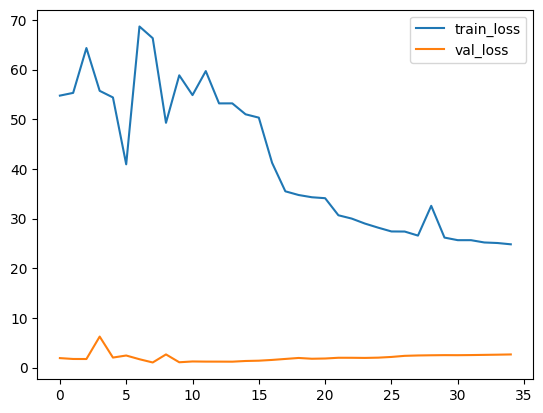

501/501 [==============================] - 9s 17ms/step
Fold 1 Train Predictions Sample:
[[0.9374042  0.04588912 0.01670663]
 [0.937033   0.04633325 0.01663374]
 [0.93555886 0.04734727 0.01709395]
 [0.93611115 0.0467328  0.01715612]
 [0.9386438  0.04490959 0.01644652]
 [0.9371198  0.04599895 0.01688121]
 [0.93805623 0.04528413 0.01665966]
 [0.9376368  0.04569978 0.01666338]
 [0.9390368  0.04442951 0.01653369]
 [0.9389319  0.04463656 0.01643153]
 [0.93702036 0.04604866 0.01693102]
 [0.9368189  0.04633739 0.01684377]
 [0.935906   0.04694071 0.01715322]
 [0.9315665  0.05062364 0.01780984]
 [0.92832005 0.05329537 0.01838453]
 [0.9275635  0.05440643 0.01802999]
 [0.9242924  0.05690985 0.01879779]
 [0.9274947  0.0541892  0.01831616]
 [0.9306186  0.0515843  0.01779708]
 [0.92852706 0.05338535 0.01808756]
 [0.9279941  0.05364225 0.01836367]
 [0.92596513 0.05565716 0.01837769]
 [0.9255103  0.05606616 0.01842348]
 [0.92636466 0.0553419  0.01829353]
 [0.9268714  0.05505997 0.01806862]
 [0.9259481

KeyboardInterrupt: 

In [243]:
# 将总样本索引构造为一个数组
indices = np.arange(total_samples)
for train_index, val_index in tscv.split(indices):
    print(f"\n--- Fold {fold} ---")



    # 构造训练集和验证集生成器（利用生成器按需生成数据）
    train_dataset = tf.data.Dataset.from_generator(
        lambda: sequence_generator(train_index, X_all, y_all, seq_length),
        output_signature=output_signature
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    val_dataset = tf.data.Dataset.from_generator(
        lambda: sequence_generator(val_index, X_all, y_all, seq_length),
        output_signature=output_signature
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # 构建模型，input_shape 为 (seq_length, input_dim)
    model = build_model(input_shape=(seq_length, input_dim))
    model.summary()
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=27, restore_best_weights=True)
    # 训练模型
    history = model.fit(train_dataset,
                        epochs=num_epochs,
                        validation_data=val_dataset,callbacks=[early_stopping,reduce_lr],class_weight=class_weight,
                        verbose=2)
    # 在验证集上评估模型
    #val_loss = model.evaluate(val_dataset, verbose=0)
    #print(f"Fold {fold} Validation Loss: {val_loss:.6f}")
    
        # 可视化损失
    
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()
    # --------------------------------------
    # 使用训练集进行预测，观察输出是否一致
    # --------------------------------------
    #train_predictions = model.predict(train_dataset, batch_size=batch_size)
    train_predictions = model.predict(val_dataset, batch_size=batch_size)
    
    print(f"Fold {fold} Train Predictions Sample:")
    print(train_predictions[:50])
    print(f"Fold {fold} Train Predictions Variance: {np.var(train_predictions):.6e}")
    
    predict_statistics(train_predictions)


    fold += 1

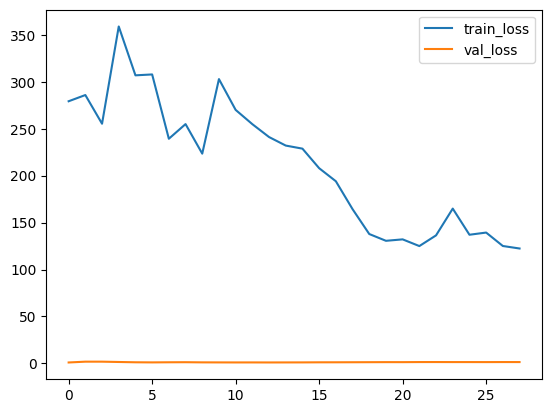

12204/12204 [==============================] - 397s 33ms/step
Fold 1 Train Predictions Sample:
[[0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8642346  0.06956238 0.06620304]
 [0.8

In [220]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
    # --------------------------------------
    # 使用训练集进行预测，观察输出是否一致
    # --------------------------------------
train_predictions = model.predict(val_dataset, batch_size=batch_size)
print(f"Fold {fold} Train Predictions Sample:")
print(train_predictions[:50])
print(f"Fold {fold} Train Predictions Variance: {np.var(train_predictions):.6e}")

In [222]:
predict_statistics(train_predictions)

每列的均值: [0.864012   0.06940867 0.06633272]
每列的最大值: [0.8642346  0.06956238 0.06620304]
每列的最小值: [0.8642346  0.06956238 0.06620304]
每列中 1 的次数: [195250.      0.      0.]


In [221]:
def predict_statistics(predictions):
    # 计算每列的统计信息
    means = np.mean(predictions, axis=0)  # 均值
    maxs = np.max(predictions, axis=0)    # 最大值
    mins = np.min(predictions, axis=0)    # 最小值
    # 打印结果
    print("每列的均值:", means)
    print("每列的最大值:", maxs)
    print("每列的最小值:", mins)
    #找到每行最大值的索引
    max_indices = np.argmax(predictions, axis=1)

    # 创建一个全零数组，shape 与 train_predictions 相同
    one_hot = np.zeros_like(predictions)

    # 将最大值位置标记为 1
    one_hot[np.arange(len(max_indices)), max_indices] = 1

    # 统计每列中 1 的次数
    counts = np.sum(one_hot, axis=0)

    # 打印结果
    print("每列中 1 的次数:", counts)

train data(8175, 3)

每列的均值: [0.73707956 0.14204124 0.12087925]

每列的最大值: [1.         1.         0.99999857]

每列的最小值: [5.3541595e-11 1.6682273e-14 3.4969445e-20]

每列中 1 的次数: [6052. 1163.  960.]

--- Fold 1 ---
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 lstm_29 (LSTM)              (None, 256)               294912    
                                                                 
 dropout_53 (Dropout)        (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 256)               65792     
                                                                 
 dropout_54 (Dropout)        (None, 256)               0         
                                                                 
 dense_54 (Dense)            (None, 3)                 771       
                                                                 
=================================================================
Total params: 361,475
Trainable params: 361,475
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric PerClassPrecision implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
12204/12204 - 683s - loss: 152.9196 - accuracy: 0.8529 - class1_accuracy: 0.2046 - class2_accuracy: 0.2930 - class0_accuracy: 0.8737 - val_loss: 1.1338 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 0.0010 - 683s/epoch - 56ms/step
Epoch 2/200
12204/12204 - 715s - loss: 170.4310 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.1395 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 0.0010 - 715s/epoch - 59ms/step
Epoch 3/200
12204/12204 - 719s - loss: 170.6495 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.1395 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 0.0010 - 719s/epoch - 59ms/step
Epoch 4/200
12204/12204 - 719s - loss: 170.6497 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.1395 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 0.0010 - 719s/epoch - 59ms/step
Epoch 5/200
12204/12204 - 702s - loss: 177.3042 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0857 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 5.0000e-04 - 702s/epoch - 57ms/step
Epoch 6/200
12204/12204 - 701s - loss: 173.1981 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0839 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 5.0000e-04 - 701s/epoch - 57ms/step
Epoch 7/200
12204/12204 - 698s - loss: 173.0595 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0838 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 5.0000e-04 - 698s/epoch - 57ms/step
Epoch 8/200
12204/12204 - 697s - loss: 173.0553 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0838 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 5.0000e-04 - 697s/epoch - 57ms/step
Epoch 9/200
12204/12204 - 696s - loss: 173.0552 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0837 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 5.0000e-04 - 696s/epoch - 57ms/step
Epoch 10/200
12204/12204 - 696s - loss: 173.0552 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0837 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 5.0000e-04 - 696s/epoch - 57ms/step
Epoch 11/200
12204/12204 - 695s - loss: 173.0553 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0837 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 5.0000e-04 - 695s/epoch - 57ms/step
Epoch 12/200
12204/12204 - 695s - loss: 178.8430 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0547 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 2.5000e-04 - 695s/epoch - 57ms/step
Epoch 13/200
12204/12204 - 694s - loss: 175.0541 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0493 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 2.5000e-04 - 694s/epoch - 57ms/step
Epoch 14/200
12204/12204 - 691s - loss: 174.3617 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0482 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 2.5000e-04 - 691s/epoch - 57ms/step
Epoch 15/200
12204/12204 - 692s - loss: 174.2376 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0480 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 2.5000e-04 - 692s/epoch - 57ms/step
Epoch 16/200
12204/12204 - 693s - loss: 174.2161 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0480 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 2.5000e-04 - 693s/epoch - 57ms/step
Epoch 17/200
12204/12204 - 696s - loss: 174.2126 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0480 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 2.5000e-04 - 696s/epoch - 57ms/step
Epoch 18/200
12204/12204 - 695s - loss: 174.2122 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0480 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 2.5000e-04 - 695s/epoch - 57ms/step
Epoch 19/200
12204/12204 - 698s - loss: 177.7649 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0383 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.2500e-04 - 698s/epoch - 57ms/step
Epoch 20/200
12204/12204 - 695s - loss: 175.9796 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0339 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.2500e-04 - 695s/epoch - 57ms/step
Epoch 21/200
12204/12204 - 694s - loss: 175.2157 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0324 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.2500e-04 - 694s/epoch - 57ms/step
Epoch 22/200
12204/12204 - 738s - loss: 174.8867 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0315 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.2500e-04 - 738s/epoch - 60ms/step
Epoch 23/200
12204/12204 - 764s - loss: 174.7498 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0311 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.2500e-04 - 764s/epoch - 63ms/step
Epoch 24/200
12204/12204 - 767s - loss: 174.6921 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0310 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.2500e-04 - 767s/epoch - 63ms/step
Epoch 25/200
12204/12204 - 764s - loss: 174.6681 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0310 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.2500e-04 - 764s/epoch - 63ms/step
Epoch 26/200
12204/12204 - 773s - loss: 174.6584 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0309 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.2500e-04 - 773s/epoch - 63ms/step
Epoch 27/200
12204/12204 - 810s - loss: 174.6547 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0309 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.2500e-04 - 810s/epoch - 66ms/step
Epoch 28/200
12204/12204 - 744s - loss: 176.5448 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0282 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 744s/epoch - 61ms/step
Epoch 29/200
12204/12204 - 711s - loss: 175.9405 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0263 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 711s/epoch - 58ms/step
Epoch 30/200
12204/12204 - 638s - loss: 175.5460 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0253 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 638s/epoch - 52ms/step
Epoch 31/200
12204/12204 - 615s - loss: 175.2888 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0244 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 615s/epoch - 50ms/step
Epoch 32/200
12204/12204 - 612s - loss: 175.1230 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0241 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 612s/epoch - 50ms/step
Epoch 33/200
12204/12204 - 615s - loss: 175.0097 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0237 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 615s/epoch - 50ms/step
Epoch 34/200
12204/12204 - 615s - loss: 174.9389 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0234 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 615s/epoch - 50ms/step
Epoch 35/200
12204/12204 - 660s - loss: 174.8929 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0232 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 660s/epoch - 54ms/step
Epoch 36/200
12204/12204 - 644s - loss: 174.8630 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0232 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 644s/epoch - 53ms/step
Epoch 37/200
12204/12204 - 626s - loss: 174.8437 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0231 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 626s/epoch - 51ms/step
Epoch 38/200
12204/12204 - 623s - loss: 174.8313 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0231 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 623s/epoch - 51ms/step
Epoch 39/200
12204/12204 - 629s - loss: 174.8232 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0231 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 629s/epoch - 52ms/step
Epoch 40/200
12204/12204 - 626s - loss: 174.8181 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0231 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 6.2500e-05 - 626s/epoch - 51ms/step
Epoch 41/200
12204/12204 - 627s - loss: 175.7815 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0225 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 627s/epoch - 51ms/step
Epoch 42/200
12204/12204 - 623s - loss: 175.6055 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0217 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 623s/epoch - 51ms/step
Epoch 43/200
12204/12204 - 628s - loss: 175.4650 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0215 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 628s/epoch - 51ms/step
Epoch 44/200
12204/12204 - 627s - loss: 175.3501 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0211 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 627s/epoch - 51ms/step
Epoch 45/200
12204/12204 - 629s - loss: 175.2576 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0207 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 629s/epoch - 52ms/step
Epoch 46/200
12204/12204 - 628s - loss: 175.1831 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0203 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 628s/epoch - 51ms/step
Epoch 47/200
12204/12204 - 632s - loss: 175.1228 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0202 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 632s/epoch - 52ms/step
Epoch 48/200
12204/12204 - 631s - loss: 175.0740 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0200 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 631s/epoch - 52ms/step
Epoch 49/200
12204/12204 - 635s - loss: 175.0348 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0198 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 635s/epoch - 52ms/step
Epoch 50/200
12204/12204 - 663s - loss: 174.9981 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0200 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 663s/epoch - 54ms/step
Epoch 51/200
12204/12204 - 650s - loss: 174.9728 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0198 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 650s/epoch - 53ms/step
Epoch 52/200
12204/12204 - 706s - loss: 174.9522 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0198 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 3.1250e-05 - 706s/epoch - 58ms/step
Epoch 53/200
12204/12204 - 693s - loss: 175.4286 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0195 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.5625e-05 - 693s/epoch - 57ms/step
Epoch 54/200
12204/12204 - 640s - loss: 175.3744 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0193 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.5625e-05 - 640s/epoch - 52ms/step
Epoch 55/200
12204/12204 - 632s - loss: 175.3259 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0191 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.5625e-05 - 632s/epoch - 52ms/step
Epoch 56/200
12204/12204 - 778s - loss: 175.2822 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0189 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.5625e-05 - 778s/epoch - 64ms/step
Epoch 57/200
12204/12204 - 821s - loss: 175.2428 - accuracy: 0.8690 - class1_accuracy: 0.0000e+00 - class2_accuracy: 0.0000e+00 - class0_accuracy: 0.8690 - val_loss: 1.0187 - val_accuracy: 0.6556 - val_class1_accuracy: 0.0000e+00 - val_class2_accuracy: 0.0000e+00 - val_class0_accuracy: 0.6556 - lr: 1.5625e-05 - 821s/epoch - 67ms/step
Epoch 58/200

In [154]:
indices

array([    0,     1,     2, ..., 49037, 49038, 49039])

In [153]:
y_all.shape

(49520,)

In [155]:
# 构造训练集和验证集生成器（利用生成器按需生成数据）
test_dataset = tf.data.Dataset.from_generator(
        lambda: sequence_generator(indices, X_all, y_all, seq_length),
        output_signature=output_signature
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [156]:
test_predictions = model.predict(test_dataset, batch_size=batch_size)

3065/3065 [==============================] - 40s 13ms/step


In [160]:
test_predictions.shape
predict_statistics(test_predictions)


每列的均值: [0.29894814 0.41583756 0.2852083 ]
每列的最大值: [1. 1. 1.]
每列的最小值: [5.3541595e-11 4.5379284e-19 8.7022583e-21]
每列中 1 的次数: [13235. 21828. 13977.]
